In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data

subroutine.py

In [2]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

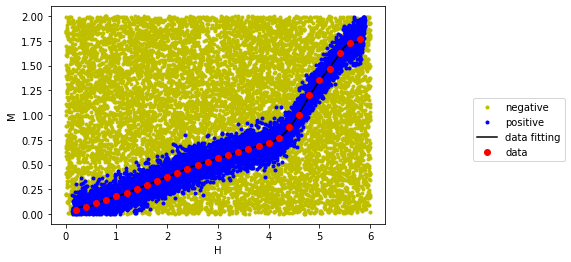

In [3]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [4]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, pi, eta=None):
    ''' returning Pi'''
    F=pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self, coef_list=None):
        penalty=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            if H==self.Hs[9]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = penalty + c_reg2*(1/self.eta_fin - H(self.one))**2
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta)
        ff=f(phi, pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(ff, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, pi=None, answer=None, reg_coef_list=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [10]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.003
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = torch.optim.Adam(Test.parameters())
Test.train()
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(c_reg1*eta(i, eta_ini, eta_fin, N_layer)**4)
    
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print("H: ", np.array(a))
print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))

H:  [1.9982003 3.7934208 2.214325  1.8336247 1.4086312 2.736052  2.6133573
 1.8575256 2.381372  2.3911588]
m2: 0.9273939728736877, lambda: 0.16071471571922302, alpha: -0.14870432019233704, beta: -0.07025880366563797


# 3. Train NN

In [11]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('M', fontsize=12)
    al.set_ylabel('H', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

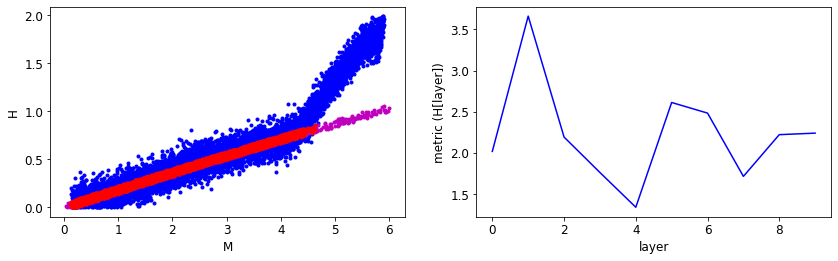

training epoch: 0,   loss: 0.15295220911502838
m2: 0.8997915983200073, lambda: 0.14218533039093018, alpha: -0.1300760954618454, beta: -0.06182948499917984
[2.01774597 3.66122866 2.19186592 1.76162326 1.33922672 2.61185241
 2.48296714 1.71415937 2.22107673 2.23947573]


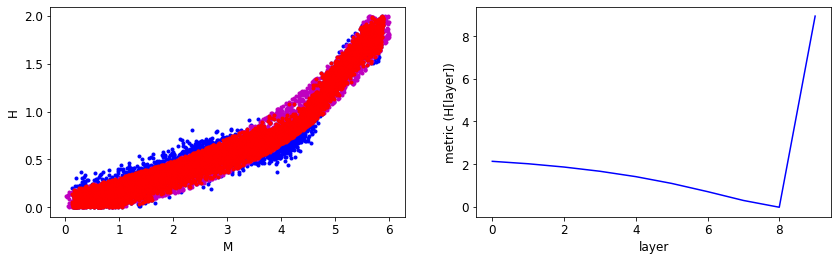

training epoch: 100,   loss: 0.011164274998009205
m2: 0.37303629517555237, lambda: -0.9727535843849182, alpha: -0.10361076891422272, beta: -0.024247486144304276
[ 2.12307262  2.00864983  1.85472524  1.65666413  1.40427232  1.08593595
  0.7009384   0.28671128 -0.03197605  8.93739414]


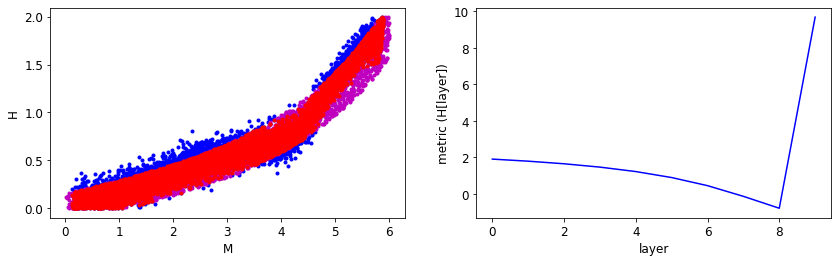

training epoch: 200,   loss: 0.011851872317492962
m2: 0.32768571376800537, lambda: -0.9365543127059937, alpha: -0.10345328599214554, beta: -0.031227661296725273
[ 1.89984763  1.7865634   1.64397705  1.46057892  1.21687949  0.88838995
  0.44377089 -0.1422704  -0.79495633  9.68819714]


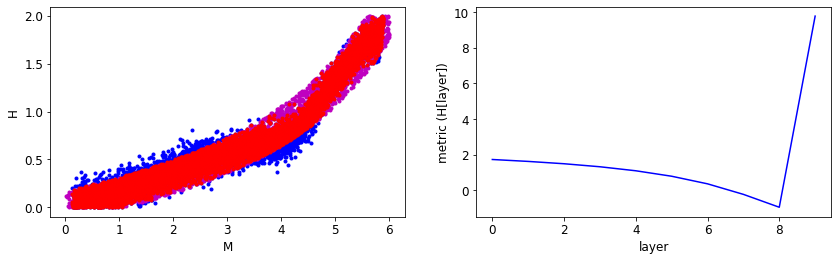

training epoch: 300,   loss: 0.01103619858622551
m2: 0.2761048376560211, lambda: -0.886059045791626, alpha: -0.10677198320627213, beta: -0.03335011377930641
[ 1.72433794  1.61725223  1.48635387  1.3171978   1.09230447  0.7860623
  0.36026222 -0.23015009 -0.95215631  9.76233673]


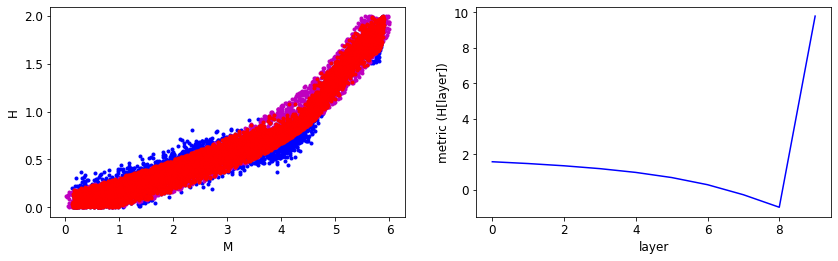

training epoch: 400,   loss: 0.010937346145510674
m2: 0.23663748800754547, lambda: -0.8259584307670593, alpha: -0.11066138744354248, beta: -0.037745971232652664
[ 1.57016635  1.46860969  1.34223473  1.18128657  0.96879423  0.67987871
  0.27608505 -0.28985029 -0.99481606  9.78085136]


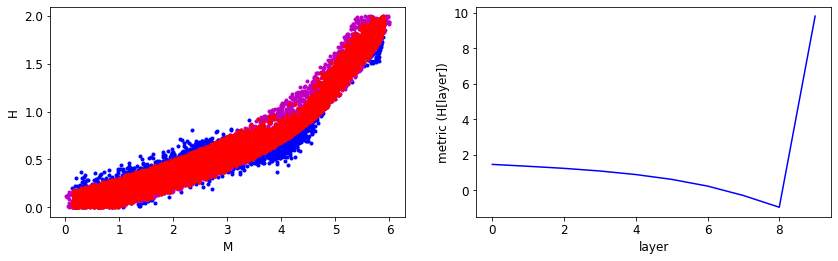

training epoch: 500,   loss: 0.010662884451448917
m2: 0.19379234313964844, lambda: -0.7536505460739136, alpha: -0.11501362919807434, beta: -0.04023493081331253
[ 1.44812703  1.34213531  1.22566617  1.07601106  0.87640673  0.60457927
  0.22542487 -0.30534142 -0.96820956  9.81254005]


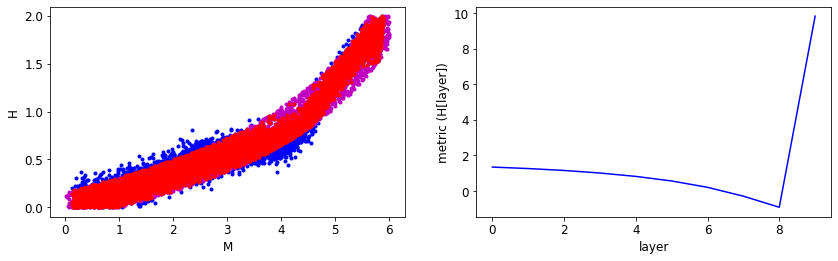

training epoch: 600,   loss: 0.010902716778218746
m2: 0.16945721209049225, lambda: -0.6705900430679321, alpha: -0.11327792704105377, beta: -0.04210616275668144
[ 1.34019792  1.25706661  1.14998472  1.00598407  0.8157478   0.55838013
  0.20118998 -0.29738826 -0.91946316  9.83303642]


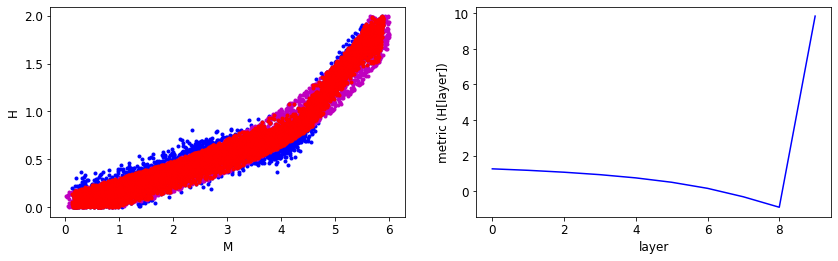

training epoch: 700,   loss: 0.01050163060426712
m2: 0.14378365874290466, lambda: -0.6054419875144958, alpha: -0.11717142909765244, beta: -0.04511844366788864
[ 1.25130308  1.16802549  1.06128013  0.92388368  0.74219716  0.49591935
  0.15364645 -0.32242194 -0.91032225  9.84758377]


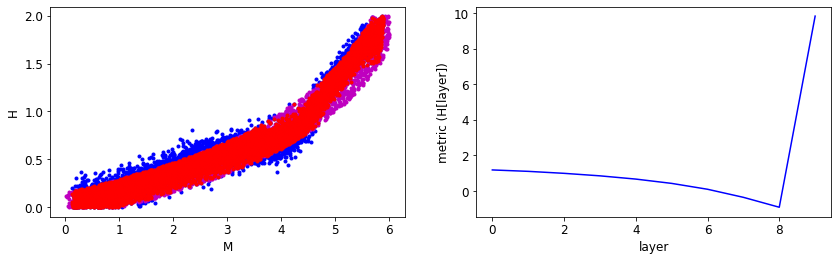

training epoch: 800,   loss: 0.010365214198827744
m2: 0.1252855509519577, lambda: -0.5465599298477173, alpha: -0.1225408986210823, beta: -0.05007452145218849
[ 1.17837608  1.09876108  0.98725694  0.84595025  0.66344368  0.42120299
  0.09078794 -0.36344528 -0.92147624  9.83644199]


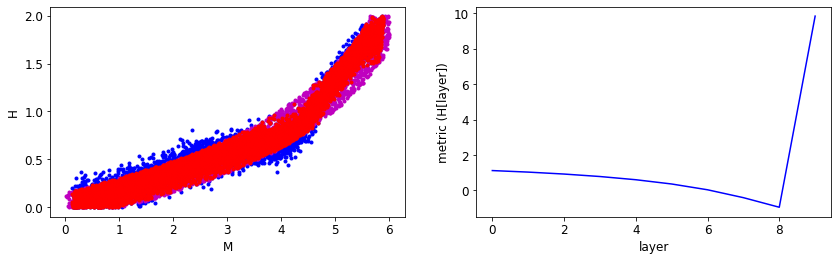

training epoch: 900,   loss: 0.010422111488878727
m2: 0.11089212447404861, lambda: -0.49165913462638855, alpha: -0.12604649364948273, beta: -0.050288110971450806
[ 1.11828625  1.03174281  0.92172652  0.78256994  0.60138655  0.36060402
  0.03393595 -0.41084433 -0.95160979  9.83506012]


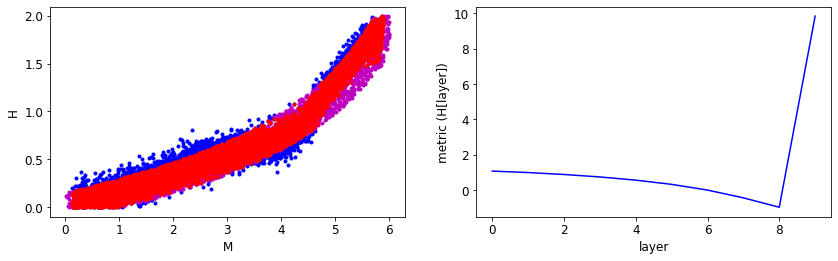

training epoch: 1000,   loss: 0.010038947686553001
m2: 0.10046567022800446, lambda: -0.45210856199264526, alpha: -0.1297890543937683, beta: -0.0541495643556118
[ 1.06656361e+00  9.84017372e-01  8.74857545e-01  7.34987617e-01
  5.54449499e-01  3.15596879e-01 -8.19486566e-03 -4.48130190e-01
 -9.79678273e-01  9.84059238e+00]


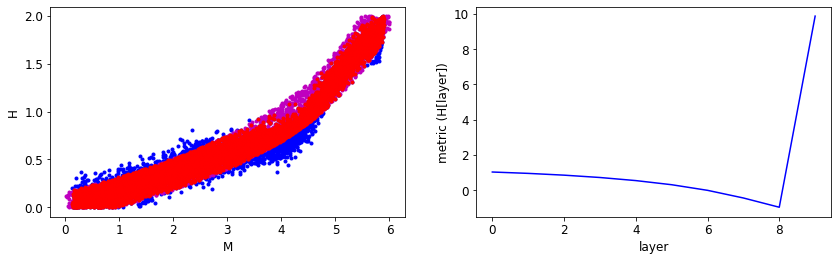

training epoch: 1100,   loss: 0.010402684099972248
m2: 0.09337621927261353, lambda: -0.4143490195274353, alpha: -0.1375964730978012, beta: -0.052958160638809204
[ 1.02535629  0.94804311  0.84712273  0.71431071  0.5389728   0.30475789
 -0.01381843 -0.44788176 -0.97325033  9.87048531]


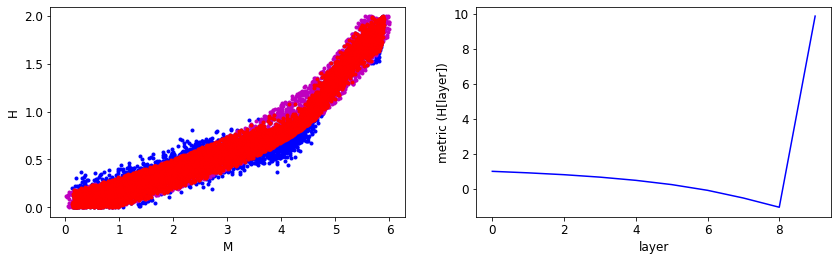

training epoch: 1200,   loss: 0.0103473961353302
m2: 0.08773814886808395, lambda: -0.3838440775871277, alpha: -0.14057469367980957, beta: -0.0552450530230999
[ 0.99493998  0.90841681  0.8029533   0.66380674  0.48110929  0.23841172
 -0.08865181 -0.52875799 -1.05468035  9.85372353]


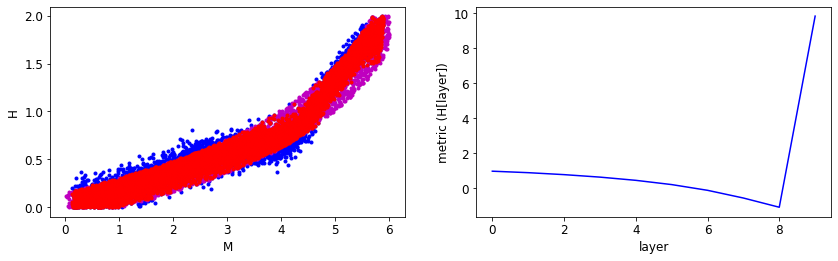

training epoch: 1300,   loss: 0.010387450456619263
m2: 0.08156329393386841, lambda: -0.3547837436199188, alpha: -0.1409524828195572, beta: -0.05745529383420944
[ 0.97206444  0.88730258  0.77507865  0.63298935  0.44915625  0.20606828
 -0.12182461 -0.5629679  -1.09034407  9.84323788]


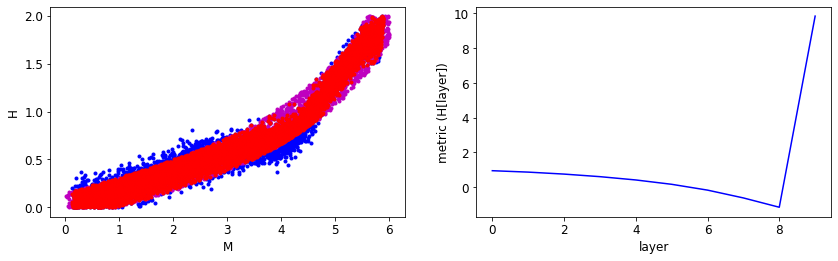

training epoch: 1400,   loss: 0.010364707559347153
m2: 0.08192751556634903, lambda: -0.3365703523159027, alpha: -0.14595304429531097, beta: -0.059619393199682236
[ 0.95208871  0.87103701  0.75700086  0.60950285  0.41936836  0.16963466
 -0.16524597 -0.61479139 -1.15044272  9.84709549]


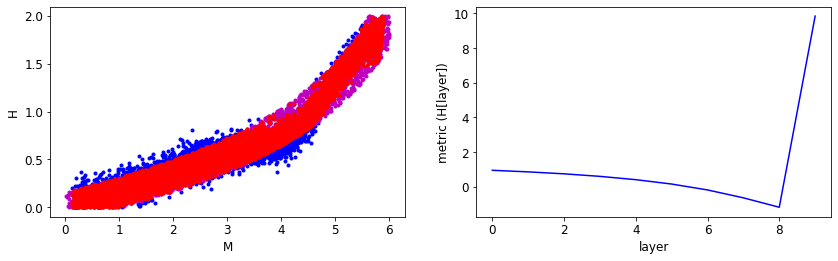

training epoch: 1500,   loss: 0.010575219057500362
m2: 0.07720180600881577, lambda: -0.3204769790172577, alpha: -0.1474362462759018, beta: -0.05987570062279701
[ 0.93908596  0.8479529   0.73493332  0.58861965  0.39758721  0.14463417
 -0.19574155 -0.65182942 -1.19487083  9.8438158 ]


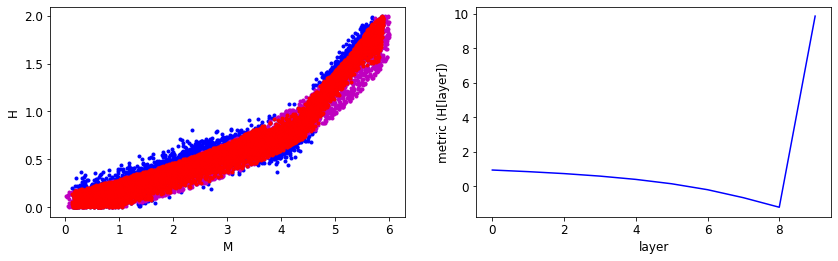

training epoch: 1600,   loss: 0.010507323779165745
m2: 0.07125575095415115, lambda: -0.3094291388988495, alpha: -0.14877383410930634, beta: -0.06264027208089828
[ 0.92928994  0.8357352   0.72273654  0.57673389  0.38622722  0.13274485
 -0.21080197 -0.67462885 -1.22785079  9.85091782]


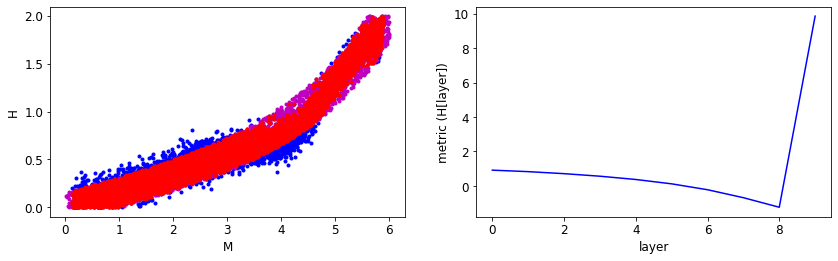

training epoch: 1700,   loss: 0.010643904097378254
m2: 0.07304907590150833, lambda: -0.29997462034225464, alpha: -0.15297651290893555, beta: -0.06178635358810425
[ 0.91754174  0.83202708  0.71467841  0.56695211  0.37674832  0.12421084
 -0.21770269 -0.67932981 -1.23299229  9.85154057]


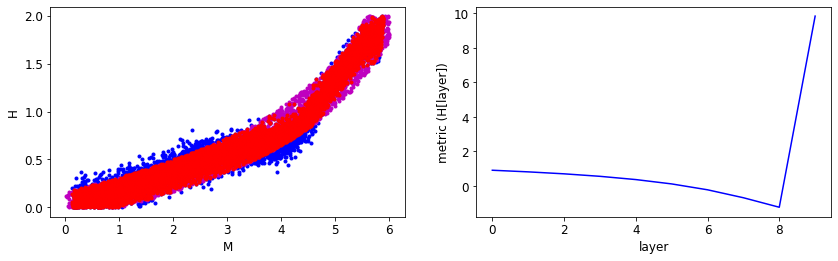

training epoch: 1800,   loss: 0.01091016922146082
m2: 0.06912671029567719, lambda: -0.2952689230442047, alpha: -0.15375439822673798, beta: -0.061007753014564514
[ 0.9112587   0.81724924  0.70318651  0.55875784  0.37014017  0.11840033
 -0.22270814 -0.68319297 -1.23429871  9.84751415]


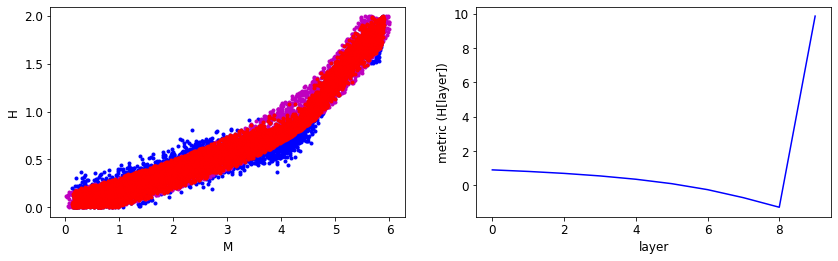

training epoch: 1900,   loss: 0.010152075439691544
m2: 0.07103399187326431, lambda: -0.29633429646492004, alpha: -0.1565343141555786, beta: -0.06293253600597382
[ 0.90217245  0.81150538  0.69793773  0.55009907  0.35688418  0.09944961
 -0.24897242 -0.71740437 -1.27419889  9.85732555]


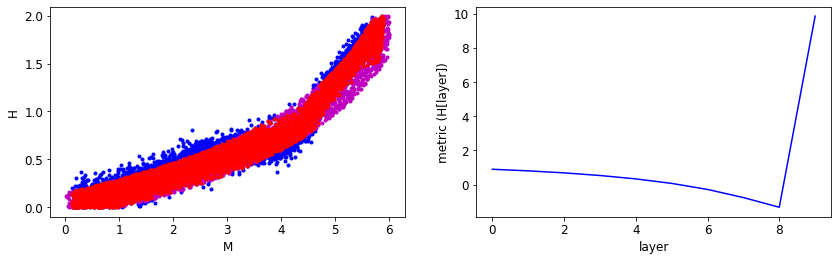

training epoch: 2000,   loss: 0.010340464301407337
m2: 0.06905835121870041, lambda: -0.28656208515167236, alpha: -0.15430140495300293, beta: -0.06594415009021759
[ 0.90364707  0.81055963  0.69239998  0.53985447  0.3411718   0.07833316
 -0.27556837 -0.75028569 -1.31496906  9.84902668]


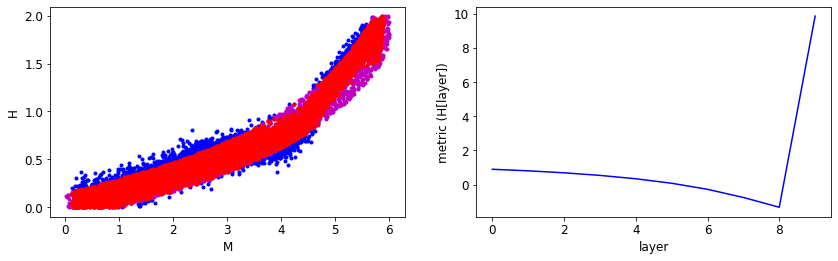

training epoch: 2100,   loss: 0.010610640980303288
m2: 0.07084647566080093, lambda: -0.2824366092681885, alpha: -0.1556043177843094, beta: -0.06707096844911575
[ 0.89821428  0.80830592  0.69215727  0.54091221  0.34305823  0.08101996
 -0.27275628 -0.75021273 -1.32121778  9.85233784]


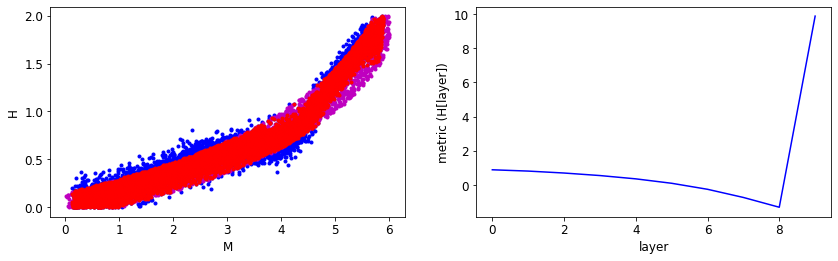

training epoch: 2200,   loss: 0.010520144365727901
m2: 0.06953383982181549, lambda: -0.27830028533935547, alpha: -0.15591926872730255, beta: -0.06639319658279419
[ 0.89303035  0.81706762  0.7035256   0.55587465  0.36261204  0.10412116
 -0.24774018 -0.72498697 -1.29712331  9.8774929 ]


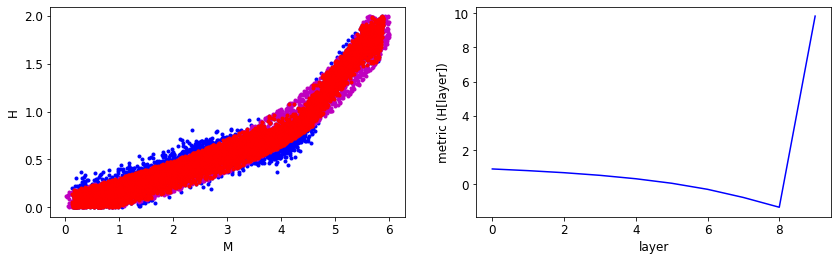

training epoch: 2300,   loss: 0.010465175844728947
m2: 0.06809240579605103, lambda: -0.2833234965801239, alpha: -0.15610761940479279, beta: -0.06404466181993484
[ 0.89348137  0.79400021  0.67453223  0.52082181  0.32094258  0.05718701
 -0.29746601 -0.77490103 -1.34629929  9.83406448]


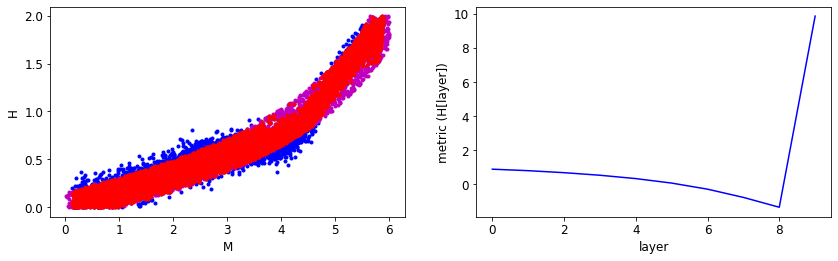

training epoch: 2400,   loss: 0.010605936869978905
m2: 0.06976025551557541, lambda: -0.2768487334251404, alpha: -0.15584175288677216, beta: -0.06439412385225296
[ 0.89060563  0.80395514  0.68647885  0.53607136  0.33953744  0.07685801
 -0.279643   -0.76131207 -1.33780241  9.85505104]


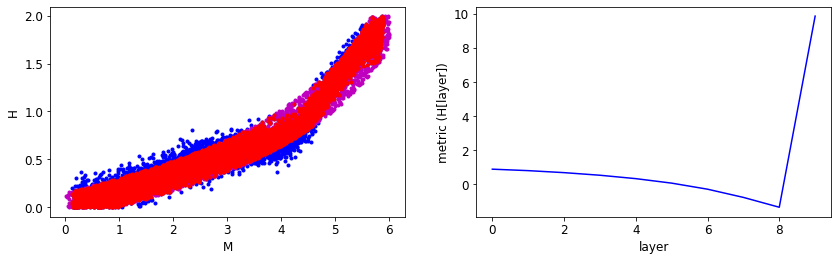

training epoch: 2500,   loss: 0.010516592301428318
m2: 0.07067370414733887, lambda: -0.275517076253891, alpha: -0.1567995846271515, beta: -0.06618640571832657
[ 0.89092708  0.80545992  0.68812644  0.53554583  0.33677846  0.07374029
 -0.2814911  -0.76174694 -1.3382175   9.85389805]


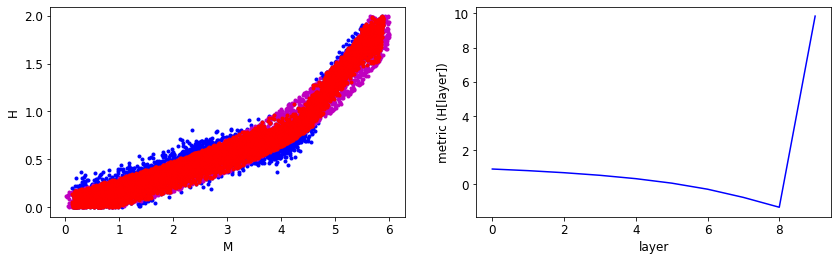

training epoch: 2600,   loss: 0.010545147582888603
m2: 0.0686827003955841, lambda: -0.27822256088256836, alpha: -0.15681886672973633, beta: -0.0656927227973938
[ 0.8890121   0.79332787  0.67356026  0.52190065  0.32488677  0.06305823
 -0.29181018 -0.77203864 -1.3481425   9.83958912]


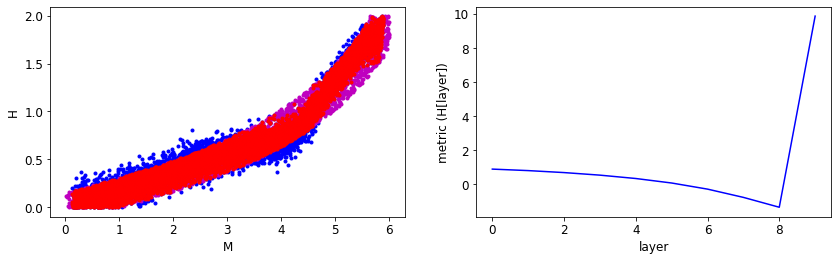

training epoch: 2700,   loss: 0.010384670458734035
m2: 0.06889282166957855, lambda: -0.2742910087108612, alpha: -0.15677466988563538, beta: -0.06538623571395874
[ 0.888547    0.80129212  0.68482357  0.53452945  0.33730307  0.0731696
 -0.28566933 -0.76989871 -1.3482219   9.86224651]


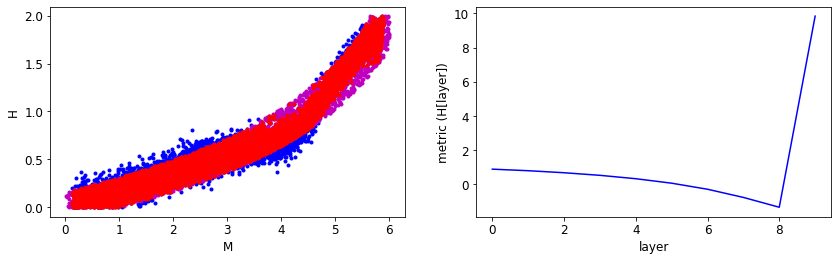

training epoch: 2800,   loss: 0.010491451248526573
m2: 0.06856150925159454, lambda: -0.273150235414505, alpha: -0.15584492683410645, beta: -0.06400182098150253
[ 0.88769174  0.79688358  0.6784631   0.52668595  0.32893029  0.06651845
 -0.2877425  -0.76605135 -1.34064651  9.8421793 ]


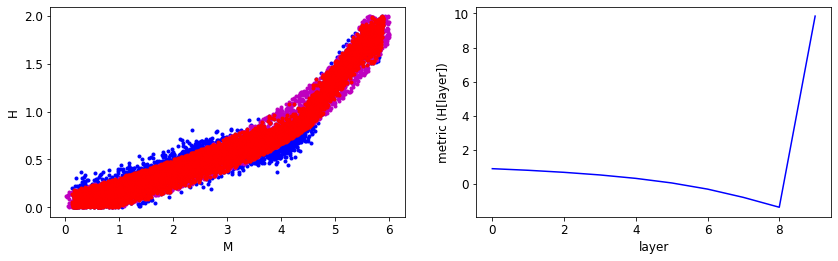

training epoch: 2900,   loss: 0.010358044877648354
m2: 0.06953594833612442, lambda: -0.27778178453445435, alpha: -0.15749233961105347, beta: -0.06509612500667572
[ 0.88712949  0.79293114  0.67305076  0.51938939  0.31796899  0.04988458
 -0.31211716 -0.79842776 -1.377074    9.84557247]


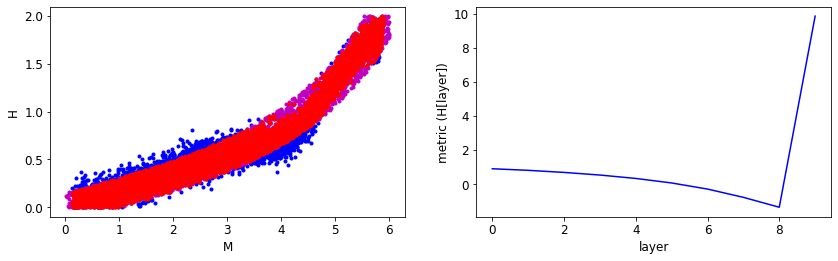

training epoch: 3000,   loss: 0.010939324274659157
m2: 0.06914354115724564, lambda: -0.2773597836494446, alpha: -0.16022808849811554, beta: -0.0666297897696495
[ 0.88981336  0.79724467  0.67473954  0.5207628   0.32081634  0.05561123
 -0.30319831 -0.78826118 -1.36966777  9.85053158]


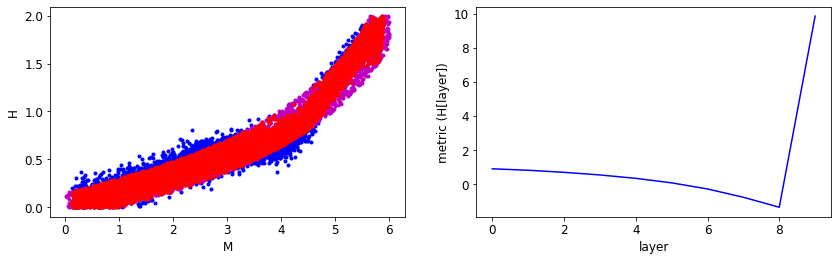

training epoch: 3100,   loss: 0.010454594157636166
m2: 0.06939776241779327, lambda: -0.27374768257141113, alpha: -0.15839214622974396, beta: -0.067160964012146
[ 0.88700396  0.80220199  0.68078566  0.52683181  0.32733008  0.06243189
 -0.29712644 -0.78488809 -1.36994195  9.85432243]


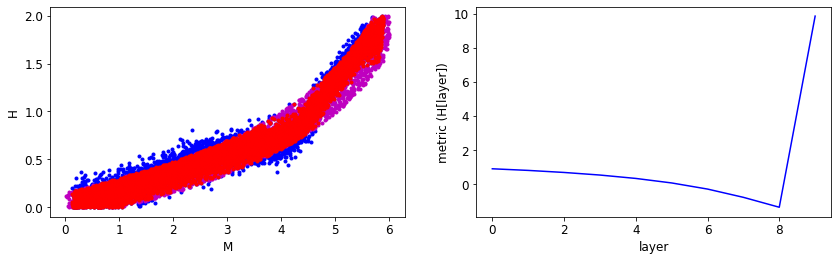

training epoch: 3200,   loss: 0.010853448882699013
m2: 0.06628625094890594, lambda: -0.26875895261764526, alpha: -0.15714876353740692, beta: -0.06535541266202927
[ 0.8903746   0.79529816  0.67498988  0.52309561  0.32435879  0.05923701
 -0.29983714 -0.78463864 -1.36603856  9.84749031]


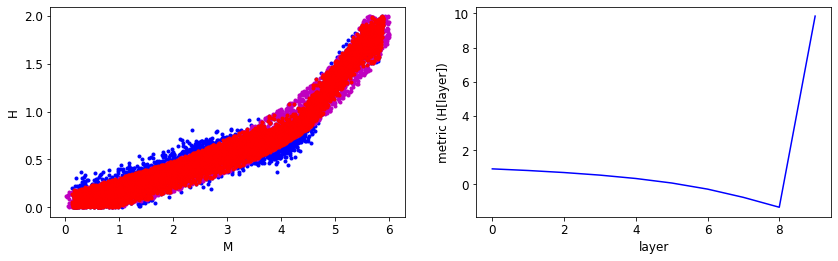

training epoch: 3300,   loss: 0.010341367684304714
m2: 0.06649303436279297, lambda: -0.2736097276210785, alpha: -0.15927128493785858, beta: -0.06487658619880676
[ 0.88818014  0.79196918  0.67284995  0.52144104  0.3235921   0.05931453
 -0.29904571 -0.78285539 -1.36211824  9.84470367]


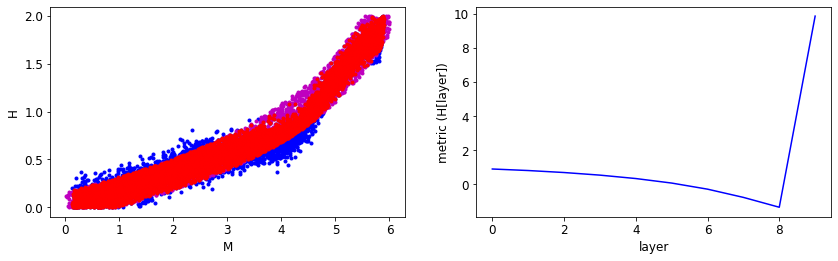

training epoch: 3400,   loss: 0.010393193922936916
m2: 0.07020030170679092, lambda: -0.2739212214946747, alpha: -0.15982285141944885, beta: -0.06476391851902008
[ 0.88400817  0.79467106  0.67762667  0.52472395  0.32476154  0.0596903
 -0.29800627 -0.78041953 -1.35830235  9.84921646]


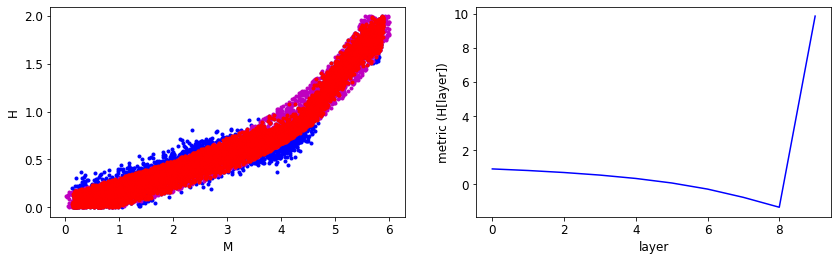

training epoch: 3500,   loss: 0.010315132327377796
m2: 0.06651711463928223, lambda: -0.27787551283836365, alpha: -0.16037112474441528, beta: -0.06534712016582489
[ 0.88583297  0.79240882  0.67474556  0.52373332  0.32550639  0.06072614
 -0.29877201 -0.78464592 -1.36512637  9.86049461]


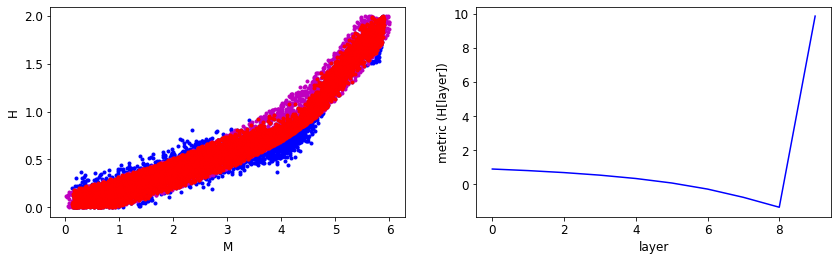

training epoch: 3600,   loss: 0.010508349165320396
m2: 0.06899222731590271, lambda: -0.2733127176761627, alpha: -0.15958882868289948, beta: -0.06283126026391983
[ 0.88337326  0.79061711  0.67432326  0.52407956  0.32729831  0.06434393
 -0.29306167 -0.7773034  -1.35864007  9.85319328]


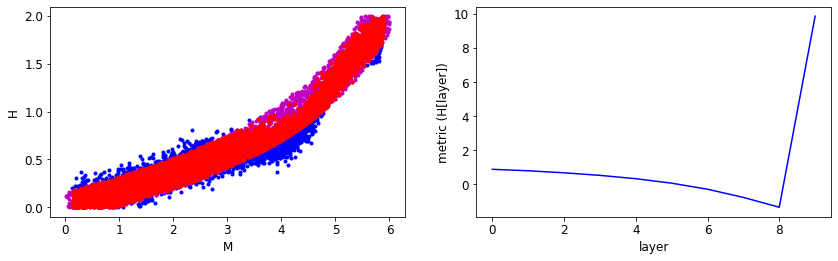

training epoch: 3700,   loss: 0.01025652140378952
m2: 0.07013428211212158, lambda: -0.2702336609363556, alpha: -0.1607273817062378, beta: -0.06383705884218216
[ 0.88447982  0.7982778   0.68060571  0.53013682  0.33378974  0.07222784
 -0.28220195 -0.76135826 -1.3370167   9.85512161]


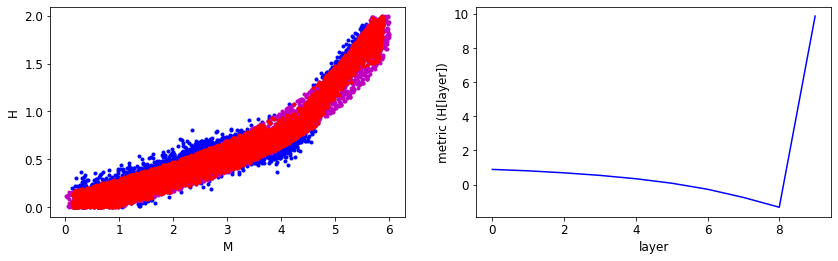

training epoch: 3800,   loss: 0.010578569956123829
m2: 0.06745205819606781, lambda: -0.2697170078754425, alpha: -0.15821194648742676, beta: -0.06660178303718567
[ 0.88560081  0.80250508  0.68591529  0.53574252  0.33956686  0.07839446
 -0.27579522 -0.75503516 -1.32956171  9.86116314]


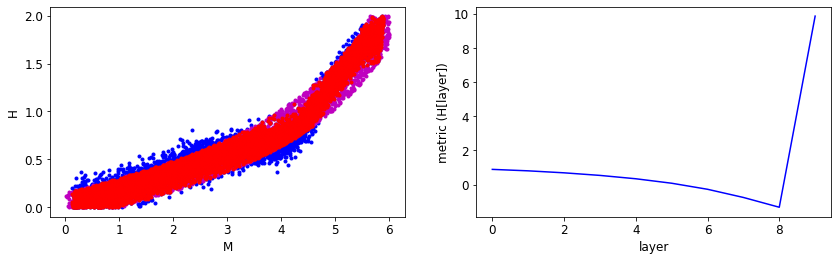

training epoch: 3900,   loss: 0.0102389482781291
m2: 0.0681634321808815, lambda: -0.27183717489242554, alpha: -0.15892131626605988, beta: -0.06639260053634644
[ 0.88579571  0.8003481   0.68401283  0.53290683  0.33616048  0.07446494
 -0.2799792  -0.75875837 -1.3320663   9.86237144]


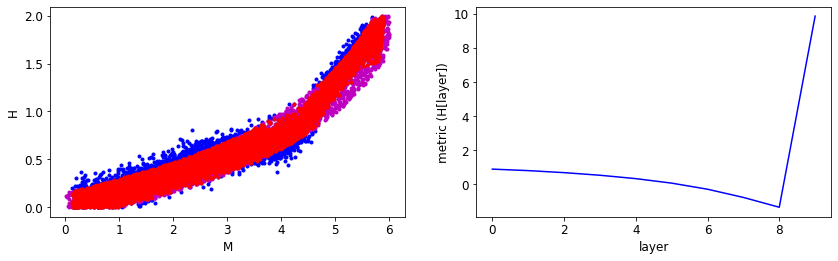

training epoch: 4000,   loss: 0.010376871563494205
m2: 0.06703813374042511, lambda: -0.27030593156814575, alpha: -0.15800656378269196, beta: -0.0669819787144661
[ 0.88919628  0.80218554  0.6835143   0.53079909  0.3321518   0.0684251
 -0.28839818 -0.76973116 -1.34471357  9.85743999]


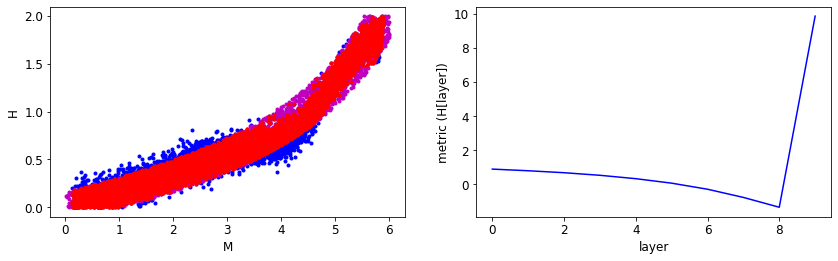

training epoch: 4100,   loss: 0.010334792546927929
m2: 0.06573839485645294, lambda: -0.2753028869628906, alpha: -0.1592133343219757, beta: -0.06394078582525253
[ 0.88736516  0.79080218  0.67586017  0.52483433  0.3265076   0.06326104
 -0.2919668  -0.7717433  -1.34700394  9.85004139]


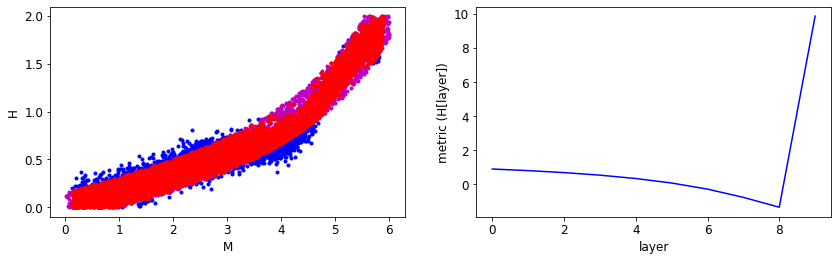

training epoch: 4200,   loss: 0.010786563158035278
m2: 0.06784860789775848, lambda: -0.2725413143634796, alpha: -0.15953907370567322, beta: -0.06416749954223633
[ 0.88850027  0.79521489  0.67822301  0.52848345  0.33114785  0.06730223
 -0.2906312  -0.77437115 -1.35310853  9.8557024 ]


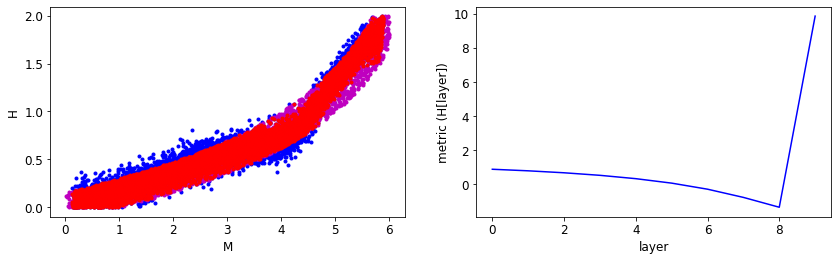

training epoch: 4300,   loss: 0.010602254420518875
m2: 0.06723419576883316, lambda: -0.2713249623775482, alpha: -0.1578103005886078, beta: -0.06667732447385788
[ 0.88782299  0.79648709  0.68150401  0.53242242  0.33663657  0.07508732
 -0.27999488 -0.76041925 -1.33697724  9.85653877]


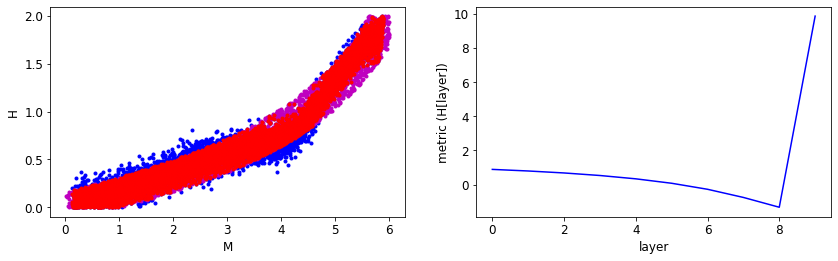

training epoch: 4400,   loss: 0.010802984237670898
m2: 0.06603337079286575, lambda: -0.2672332227230072, alpha: -0.15847808122634888, beta: -0.06346190720796585
[ 0.88975692  0.79680544  0.68129075  0.53256309  0.33789369  0.07845045
 -0.27358902 -0.75057244 -1.32398343  9.85455418]


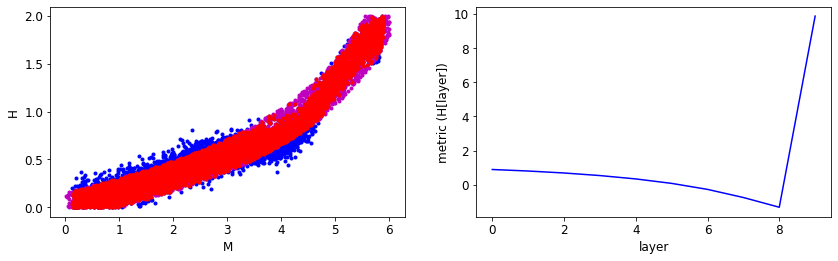

training epoch: 4500,   loss: 0.010399509221315384
m2: 0.06710875779390335, lambda: -0.27378082275390625, alpha: -0.16179150342941284, beta: -0.06636229157447815
[ 0.88928324  0.80098885  0.6854822   0.5348838   0.33811176  0.07754417
 -0.27396977 -0.74864531 -1.31791782  9.86052513]


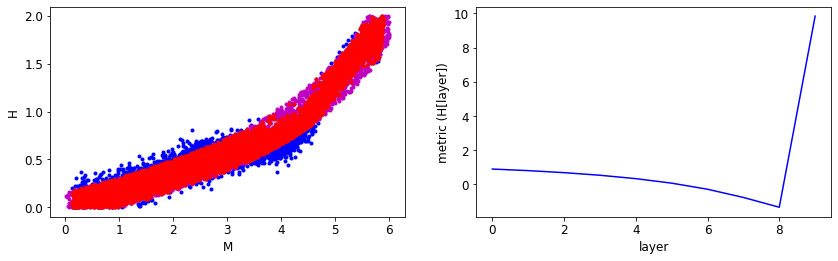

training epoch: 4600,   loss: 0.010439688339829445
m2: 0.06879119575023651, lambda: -0.2710625231266022, alpha: -0.15854208171367645, beta: -0.06475050747394562
[ 0.88713837  0.79456717  0.67628229  0.52381569  0.32507044  0.06106629
 -0.29568103 -0.77631414 -1.35033524  9.84544563]


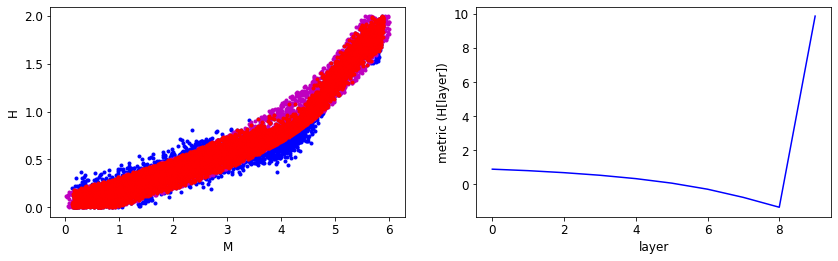

training epoch: 4700,   loss: 0.010377404280006886
m2: 0.07025548070669174, lambda: -0.26898106932640076, alpha: -0.15982124209403992, beta: -0.0636133998632431
[ 0.88682151  0.79949409  0.682046    0.53062516  0.33258674  0.06933979
 -0.28655201 -0.76733559 -1.34369504  9.85480022]


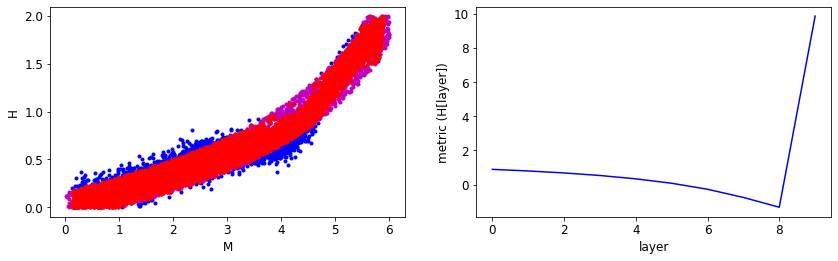

training epoch: 4800,   loss: 0.010348111391067505
m2: 0.06656181067228317, lambda: -0.26864445209503174, alpha: -0.1580200046300888, beta: -0.06277669966220856
[ 0.88804448  0.79477859  0.67870432  0.5298509   0.33499262  0.07580637
 -0.27584898 -0.75283295 -1.32642424  9.84801483]


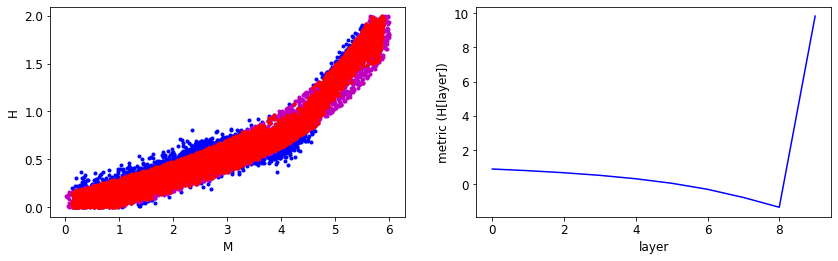

training epoch: 4900,   loss: 0.010423903353512287
m2: 0.06693720072507858, lambda: -0.27132126688957214, alpha: -0.15787896513938904, beta: -0.06554409861564636
[ 0.88944387  0.79221833  0.67208451  0.51884025  0.31989634  0.05683087
 -0.29748958 -0.77524501 -1.34703159  9.83584499]


In [12]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                         positive_H_M_F=Positive_HM, negative_H_M_F=Negative_HM, Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))
        print(np.array([v[0] for v in Hs]))